# Problem Statement
Crop diseases significantly threaten agricultural productivity and food security in Northern Nigeria. Smallholder farmers in this region heavily depend on crops like potato,  cowpea and groundnuts for their livelihoods. However, various crop diseases often severely impact their yields due to a lack of timely disease detection, limited access to agricultural extension services, and inadequate knowledge about disease management practices.
Rapid and accurate identification of crop diseases is crucial for taking prompt remedial actions and preventing further spread. However, many smallholder farmers in Northern Nigeria need more expertise to recognize disease symptoms visually, especially in the early stages. This delay in detection often leads to unchecked proliferation of diseases, resulting in substantial crop losses.

Traditional methods of disease diagnosis, such as consulting agricultural experts or sending samples to laboratories, are time-consuming and often inaccessible to resource-constrained smallholder farmers. Furthermore, the scarcity of agricultural extension workers in rural areas exacerbates the problem, leaving farmers with limited guidance on disease management strategies.

 Early blight and Late blight are major disease of potato leaf. It is estimated that the major loss occurred in potato yield is due to these diseases. Thus the images are classified into 3 classes :
- Healthy leaves     
<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse1.mm.bing.net%2Fth%3Fid%3DOIP.jW152ASG2nfRv_LCkYnzMQHaFj%26pid%3DApi&f=1" height='200' width="300"/>

- Late Blight leaves
<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse2.mm.bing.net%2Fth%3Fid%3DOIP.vCrNUKDj1Z1zErHEMQzmCQHaFj%26pid%3DApi&f=1" height='200' width="300"/>

- Early Blight leaves
<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse2.mm.bing.net%2Fth%3Fid%3DOIP.e4wvw_JVbE1yFgOYbUoVSAHaE7%26pid%3DApi&f=1" height='200' width="300"/>

In [1]:
# import libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # to disable all debugging logs

In [2]:
# importing dataset
dir = os.listdir('../input/plant-village/PlantVillage')
for filenames in dir:
    print(filenames)

Pepper__bell___Bacterial_spot
Potato___healthy
Tomato_Leaf_Mold
Tomato__Tomato_YellowLeaf__Curl_Virus
Tomato_Bacterial_spot
Tomato_Septoria_leaf_spot
Tomato_healthy
Tomato_Spider_mites_Two_spotted_spider_mite
Tomato_Early_blight
Tomato__Target_Spot
Pepper__bell___healthy
Potato___Late_blight
Tomato_Late_blight
Potato___Early_blight
Tomato__Tomato_mosaic_virus


# Extracting only potato dataset

In [3]:
!cp -rf ../input/plant-village/PlantVillage/Potato___Early_blight ./Potato___Early_blight

In [4]:
!cp -rf ../input/plant-village/PlantVillage/Potato___Late_blight ./Potato___Late_blight

In [5]:
!cp -rf ../input/plant-village/PlantVillage/Potato___healthy ./Potato___healthy

In [6]:
Current_Dir = os.getcwd()
dataset_dir = pathlib.Path(Current_Dir)


In [7]:
#Global initialization of some imp variables
Image_Size = 256
Batch_Size = 32
Channels = 3
Epochs = 40

In [8]:
#yields batches of images from the subdirectories class_a , class_b and class_c 
#together with labels 0 , 1 and 2 (0, 1, 2 corresponding to classes class_a , class_b and class_c respectively )
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir, batch_size = Batch_Size, image_size = (Image_Size, Image_Size), shuffle = True)

Found 2152 files belonging to 3 classes.


In [9]:
#Folders(classes) in 'Dataset' directory
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [10]:
len(dataset) # Number of Batches = (total number of files belonging to all classes / Batch_Size)

68

In [11]:
print(dataset) #prints Elements in dataset: here 1st element is image and 2nd index of that image.

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>


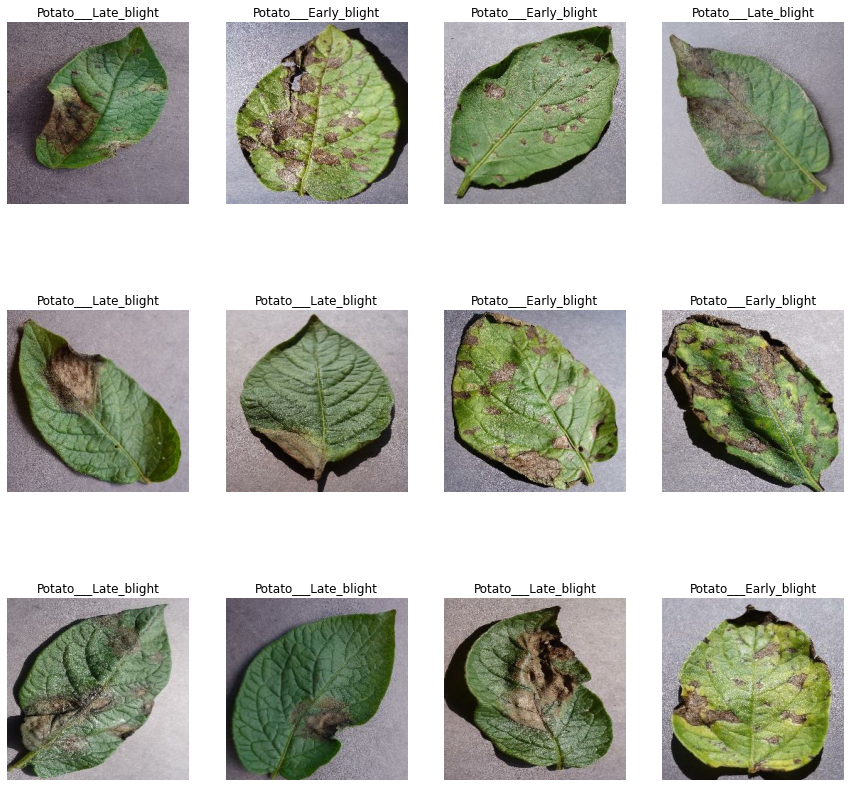

In [12]:
# Plotting the image
plt.figure(figsize = (15,15))
# dataset.take(count) : Creates a Dataset with at most 'count' elements(batch) from the dataset
for image, label in dataset.take(1): 
    for i in range(12):
        plt.subplot(3, 4, i+1) # many plots at a time =>subpots
        plt.imshow(image[i].numpy().astype('uint8')) #converting all data of image into numpy and than to intiger type as they were in float.
        plt.title(class_name[label[i]])  # title of the class_name of image
        plt.axis("off") # Hide the values of graph

# Splitting Dataset

In [13]:
# Function for Splitting the data
def split_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 10)
        
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_data, val_data, test_data = split_dataset(dataset)

In [15]:
print("Size of Data is :{0} \nBatch size of Training Data is :{1}\nBatch size of Validation Data is :{2} \nBatch size of Testing Data is :{3} " .format(len(dataset), len(train_data), len(val_data), len(test_data)))

Size of Data is :68 
Batch size of Training Data is :54
Batch size of Validation Data is :6 
Batch size of Testing Data is :8 


In [16]:
# caching,shuffle and prefetching the data
train_ds = train_data.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_data.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_data.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)

# Data Pre-processing

In [17]:
# Image Preprocessing : Rescaling and Resizing
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size, Image_Size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [18]:
# Data augmentation by flipping and rotating existing images
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(factor = 0.5)
])

# Building the model

In [19]:
# Simple model without optimizations
simple_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(Image_Size, Image_Size, Channels)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

simple_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# training the simple model
simple_history = simple_model.fit(
    train_data, 
    epochs=20, 
    validation_data=val_data
)

Epoch 1/20
54/54 [==============================] - 65s 1s/step - loss: 102.9226 - accuracy: 0.6056 - val_loss: 0.5426 - val_accuracy: 0.7917
Epoch 2/20
54/54 [==============================] - 62s 1s/step - loss: 0.6334 - accuracy: 0.7811 - val_loss: 0.3958 - val_accuracy: 0.8802
Epoch 3/20
54/54 [==============================] - 63s 1s/step - loss: 0.5000 - accuracy: 0.8420 - val_loss: 0.4989 - val_accuracy: 0.8594
Epoch 4/20
54/54 [==============================] - 62s 1s/step - loss: 0.5188 - accuracy: 0.8445 - val_loss: 0.4865 - val_accuracy: 0.8385
Epoch 5/20
54/54 [==============================] - 62s 1s/step - loss: 0.4336 - accuracy: 0.8574 - val_loss: 0.2727 - val_accuracy: 0.9167
Epoch 6/20
54/54 [==============================] - 62s 1s/step - loss: 0.3137 - accuracy: 0.9020 - val_loss: 0.2431 - val_accuracy: 0.9405
Epoch 7/20
54/54 [==============================] - 62s 1s/step - loss: 0.2719 - accuracy: 0.9149 - val_loss: 0.2167 - val_accuracy: 0.9479
Epoch 8/20
54/54 [

In [20]:
# Creating Convolution layer 
input_shape = (Batch_Size, Image_Size, Image_Size, Channels)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(64, activation = 'softmax'),

])


model.build(input_shape = input_shape)

In [21]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (32, 254, 254, 16)        448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 127, 127, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (32, 125, 125, 64)        9280      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (32, 60, 60, 128)        

In [22]:
# Optimizing the model 'SparseCategoricalCrossentropy'=>as there are many categorical classes of data
model.compile(
    optimizer = 'adam', 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), 
    metrics = ['accuracy'])

In [23]:
#Fit the model with training data and also pass validation data
history = model.fit(
train_data, epochs = Epochs, batch_size = Batch_Size, verbose = 1, validation_data = val_data)

Epoch 1/40
54/54 [==============================] - 65s 1s/step - loss: 1.2061 - accuracy: 0.4577 - val_loss: 0.9374 - val_accuracy: 0.4844
Epoch 2/40
54/54 [==============================] - 63s 1s/step - loss: 0.8136 - accuracy: 0.6068 - val_loss: 0.8392 - val_accuracy: 0.6250
Epoch 3/40
54/54 [==============================] - 64s 1s/step - loss: 0.5636 - accuracy: 0.7639 - val_loss: 0.9351 - val_accuracy: 0.6510
Epoch 4/40
54/54 [==============================] - 63s 1s/step - loss: 0.4003 - accuracy: 0.8298 - val_loss: 0.4731 - val_accuracy: 0.7969
Epoch 5/40
54/54 [==============================] - 63s 1s/step - loss: 0.2958 - accuracy: 0.8803 - val_loss: 0.2226 - val_accuracy: 0.9062
Epoch 6/40
54/54 [==============================] - 63s 1s/step - loss: 0.2775 - accuracy: 0.8844 - val_loss: 0.2305 - val_accuracy: 0.9115
Epoch 7/40
54/54 [==============================] - 63s 1s/step - loss: 0.2456 - accuracy: 0.9020 - val_loss: 0.1914 - val_accuracy: 0.9167
Epoch 8/40
54/54 [==

In [24]:
scores = model.evaluate(train_data)

54/54 [==============================] - 14s 247ms/step - loss: 0.1367 - accuracy: 0.9484


In [25]:
# Save the simple model
simple_model.save('simple_model.h5')

# Save the optimized model
model.save('optimized_model.h5')

In [26]:
history

In [27]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 54}

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
import pickle

# Save simple model history
with open('simple_model_history.pkl', 'wb') as file:
    pickle.dump(simple_history.history, file)


# Analyzing the Output

In [33]:
# Getting the model history to analyse
train_loss = history.history['loss']
train_acc = history.history['accuracy']

val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation Loss')

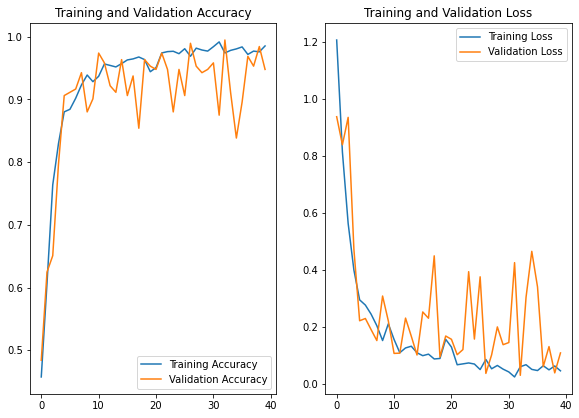

In [34]:
#graphs for accuracy and loss of training and validation data
plt.figure(figsize = (15,15))
plt.subplot(2,3,1)
plt.plot(range(Epochs), train_acc, label = 'Training Accuracy')
plt.plot(range(Epochs), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy') 

plt.subplot(2,3,2)
plt.plot(range(Epochs), train_loss, label = 'Training Loss')
plt.plot(range(Epochs), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

First Image of batch to predict :
Actual label :  Potato___Late_blight
Predicted label :  Potato___Late_blight


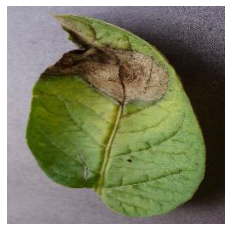

In [35]:
#plotting image
for batch_image, batch_label in train_data.take(1):
    first_image = batch_image[0].numpy().astype('uint8')
    first_label = class_name[batch_label[0]]
    
    print('First Image of batch to predict :')
    plt.imshow(first_image)
    print('Actual label : ', first_label)
    
    batch_prediction = model.predict(batch_image)
    print('Predicted label : ', class_name[np.argmax(batch_prediction[0])])
    plt.axis('off')

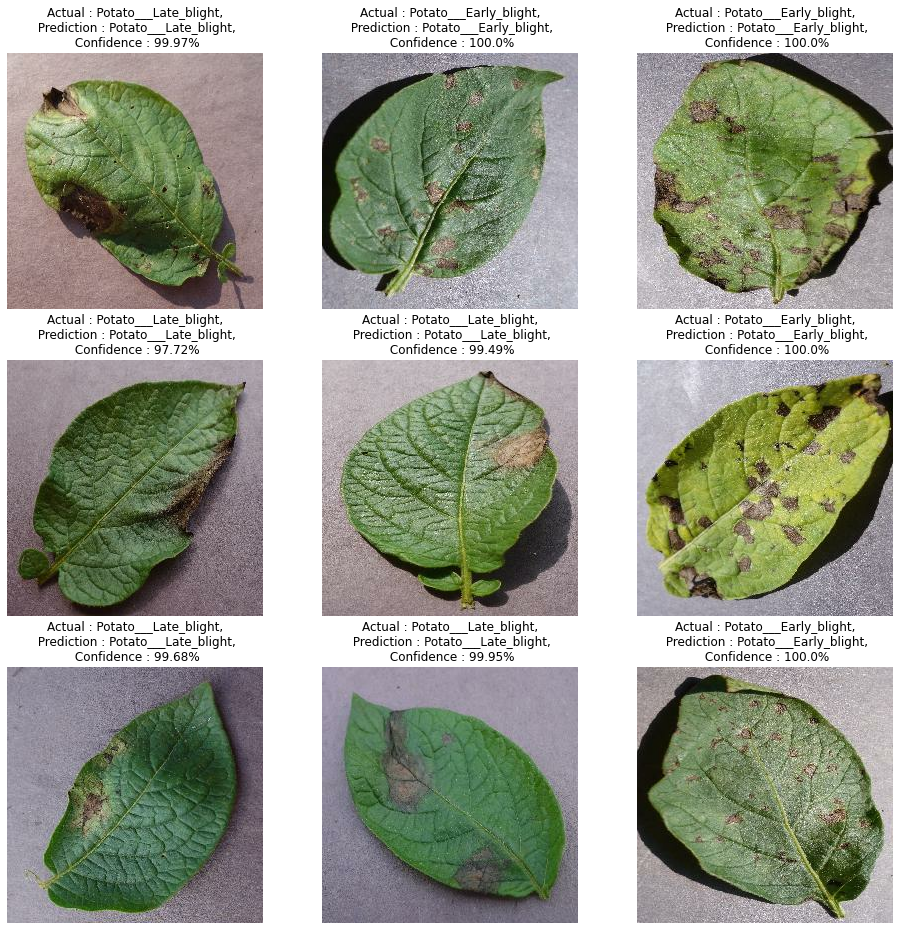

In [36]:
# plotting batch of images with its actual label, predicted label and confidence
plt.figure(figsize = (16,16))
for batch_image, batch_label in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        image = batch_image[i].numpy().astype('uint8')
        label = class_name[batch_label[i]]
    
        plt.imshow(image)
    
        batch_prediction = model.predict(batch_image)
        predicted_class = class_name[np.argmax(batch_prediction[i])]
        confidence = round(np.max(batch_prediction[i]) * 100, 2)
        
        plt.title(f'Actual : {label},\n Prediction : {predicted_class},\n Confidence : {confidence}%')
    
        plt.axis('off')